In [36]:
import pandas as pd
import numpy as np
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
import random

# General structure

```data_thchs30/
    ├── data/
    │   ├── *.wav
    │   └── *.wav.trn
    ├── train/
    │   └── ...
    ├── dev/
    │   └── ...
    ├── test/
    │   └── ...
    ├── lm_word/
    │   ├── word.3gram.lm
    │   └── lexicon.txt
    └── lm_phone/
        ├── phone.3gram.lm
        └── lexicon.txt
```

## Basic files
* `xyz.wav` is an audio file
* `xyz.trn` is a transcription for the file above

## Directories
* `data/` contains all raw audios and its transcriptions. `train/`, `dev/`, `test/` are just divided `data/`.
* `lm_word/` contains data for language models, sets probablities for next word appearance
* `lm_phone/` contains data for language models, sets probablities for next tone (phone) appearance

In [37]:
def count_files(path):
    files = 0
    for _, dirnames, filenames in os.walk(path):
        files += len(filenames)
    return files

In [38]:
dirs = {"data": 0, "train": 0, "test": 0, 'dev': 0} 
pre_path = "data_thchs30/"

for dir in dirs:
    full_path = os.path.join(pre_path, dir)
    file_count = count_files(full_path)
    dirs[dir] = file_count
    print(f'{full_path}: {dirs[dir]} files {(100 * file_count / dirs["data"]):.2f}% of all')

data_thchs30/data: 26777 files 100.00% of all
data_thchs30/train: 20000 files 74.69% of all
data_thchs30/test: 4990 files 18.64% of all
data_thchs30/dev: 1786 files 6.67% of all


All files from `data/` are splitted between training data (`train/`), validating data (`dev/`) and testing (`test/`). The split is done, so I don't have to do it manually. The proportion `train:test` is famous 80:20 (train = train + validation).

One file is missing though. It's `.wav.scp`, that appears to contain listing of some audios and paths to them --- I assume it presents the general link between `.wav` and `.trn` file types.

# Audio data

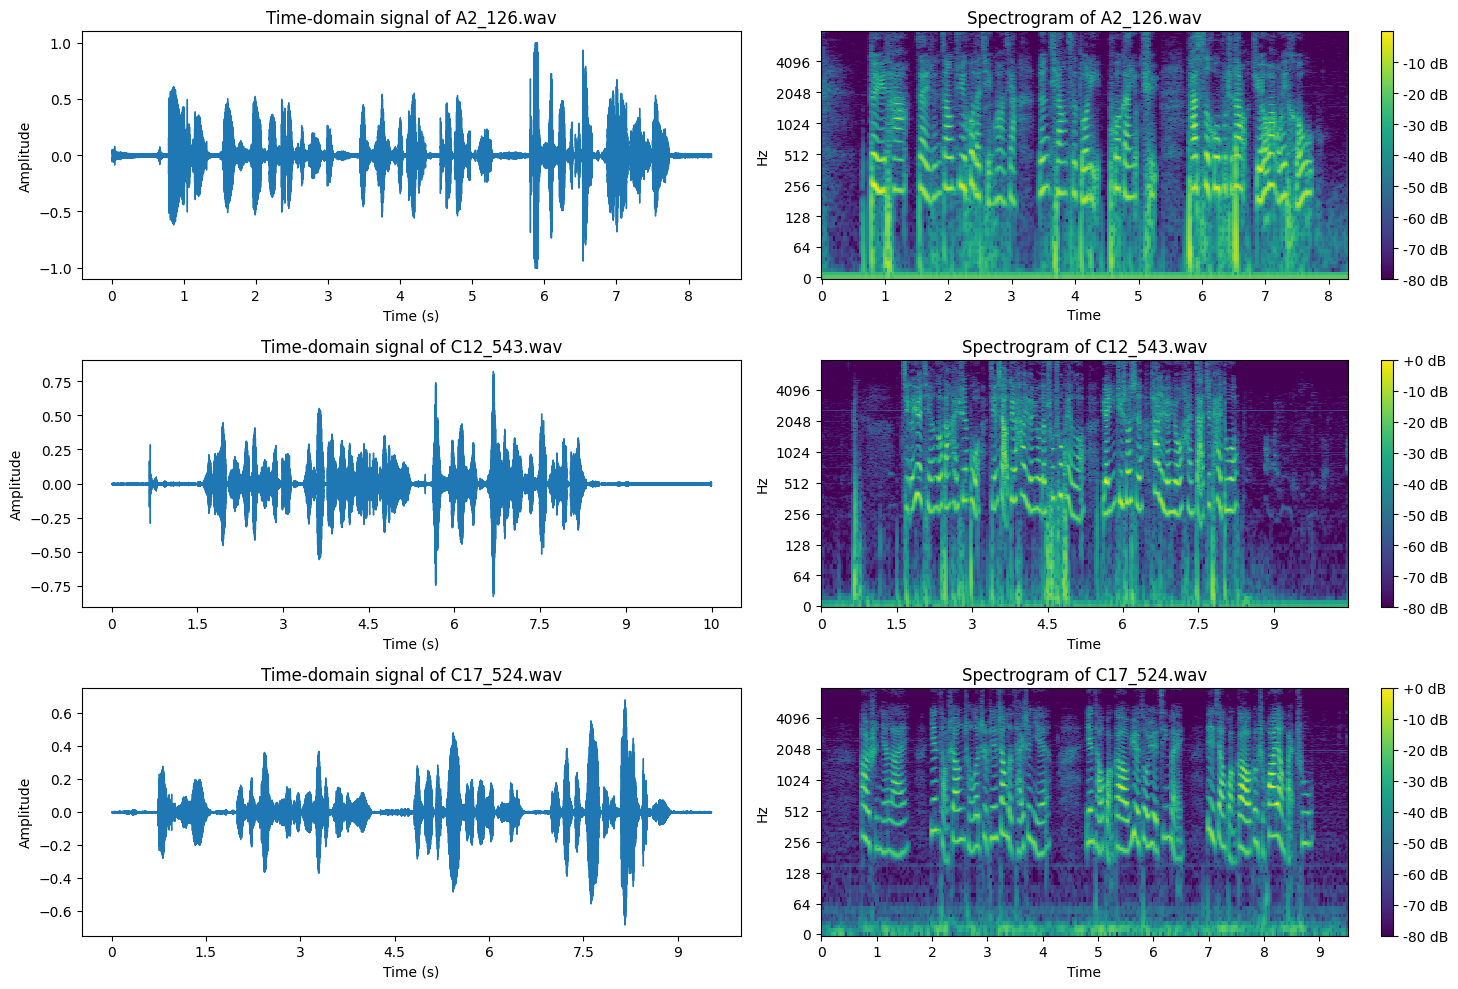

In [39]:
data_dir = "data_thchs30/data"

files = random.sample([f for f in os.listdir(data_dir) if f.endswith('.wav')], 3)

plt.figure(figsize=(15, 10))

for i, file in enumerate(files):
    file_path = os.path.join(data_dir, file)
    audio, sr = librosa.load(file_path, sr=None)
    
    # time-domain (left)
    plt.subplot(3, 2, 2 * i + 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Time-domain signal of {file}")
    
    # frequency-domain (right)
    D = librosa.stft(audio)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.subplot(3, 2, 2 * i + 2)
    librosa.display.specshow(D_db, sr=sr, x_axis="time", y_axis="log", cmap="viridis")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Spectrogram of {file}")

plt.tight_layout()
plt.show()

Is data normalized?

In [40]:
all_normalized = True

for i, file in enumerate(os.listdir(data_dir)):
    if file[-3:] == "wav":
        file_path = os.path.join(data_dir, file)
        
        audio, sr = librosa.load(file_path, sr=None)
        
        if np.max(np.abs(audio)) > 1.0:
            all_normalized = False
        
        if i > dirs['data'] / 2:
            break # let's trust them! (6k wav files should be sufficient)


if all_normalized:
    print("All? files in the directory are normalized.")
else:
    print("Some files in the directory are NOT normalized.")

All? files in the directory are normalized.


# Text data
Dataset authors' note:
```
Statistics for the data are as follows:

    ===========  ==========  ==========  ===========
    **dataset**  **audio**   **#sents**  **#words**
    ===========  ==========  ==========  ===========
        train        25        10.000      198,252
        dev         2:14         893        17,743
        test        6:15        2,495       49,085
    ===========  ==========  ==========  ===========
```